<center> <h1> Tabular Playground Series - Sep 2021 <center><h1> 


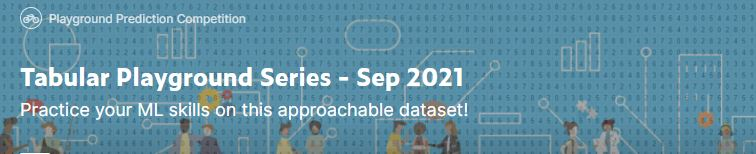

<div class="alert alert-success">
    <h1 align="center">Overview</h1>
</div>


 Kaggle competitions are incredibly fun and rewarding, but they can also be intimidating for people who are relatively new in their data science journey. In the past, Kaggle have launched many Playground competitions that are more approachable than Featured competition, and thus more beginner-friendly.
    
  For this competition, we will predict whether a customer made a claim upon an insurance policy. The ground truth claim is binary valued, but a prediction may be any number from 0.0 to 1.0, representing the probability of a claim.

## About the data 
The dataset  used for this competition is synthetic, but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting whether a claim will be made on an insurance policy. Although the features are anonymized, they have properties relating to real-world features. the data contain three files :  
* train.csv - the training data with the target claim column
* test.csv - the test set; you will be predicting the claim for each row in this file
* sample_submission.csv - a sample submission file in the correct format   

In [ ]:
#importing libraries 
import os 
import pandas as pd  
import numpy  as np
import matplotlib.pyplot as plt # ploting
from collections import Counter
import math 
%matplotlib inline
import seaborn as sns
sns.set_style("ticks")
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
print("Packages Imported ")

# Load the data 

In [ ]:
train_data = pd.read_csv('../input/tabular-playground-series-sep-2021/train.csv')
test_data = pd.read_csv('../input/tabular-playground-series-sep-2021/test.csv')
sample     = pd.read_csv('../input/tabular-playground-series-sep-2021/sample_solution.csv')

### Basic EDA to better know the data 
We first take a look at our dataframes ( train and test ). after that we will make predictions for the test data.

**Quick look at the Train Data**

In [ ]:
#quick look at the train data
train_data.head(5).style.set_properties(**{'background-color': 'white',
                           'color': 'darkblue',
                           'border-color': 'dark'})

In [ ]:
print(f'Number of rows: {train_data.shape[0]};  Number of columns: {train_data.shape[1]}; No of missing values: {sum(train_data.isna().sum())}')

The train dataset has 957919 of rows with 120 of columns and there are 1820782 missing values ( that's bad :/). we can continue for now.

In [ ]:
print("number of misssing values by feature")
train_data.isnull().sum().sort_values(ascending = False)

In [ ]:
print('Info about the train data: ')
Counter(train_data.dtypes.values)


**Basic summary statistic**


In [ ]:
train_data.describe().style.background_gradient(cmap='coolwarm')

**Features Variation**

In [ ]:
# variables variaition 
train_data.var()
#Standard  deviation  
train_data.std()

**Correlation matrix**
<p> let's check the features correlation matrix.


In [ ]:
# Correlationmatrix
corrMatrix =train_data.corr(method='pearson', min_periods=1)
corrMatrix

**Correlation with  target** 
<p> let's check whar features are more correlated to target.

In [ ]:
corr_targ = train_data.corrwith(train_data["claim"])
corr_targ 

**Target Column**
<p> The target ["claim"] for this competition which we are predicting is binary valued,.

In [ ]:
print('percentage of claim values:')
percent_value = pd.DataFrame(train_data['claim'].value_counts()/len(train_data))
percent_value.T

In [ ]:
# visualization 
countplt, ax = plt.subplots(figsize = (8,5))
ax =sns.countplot(train_data['claim'],palette="husl")

Almost equal counts but we kinda have more zeros than ones xD.

**Quick look at the Test dataset**

In [ ]:
test_data.head(5).style.set_properties(**{'background-color': 'white',
                           'color': 'darkblue',
                           'border-color': 'dark'}) # head 

In [ ]:
print(f'Number of rows: {test_data.shape[0]};  Number of columns: {test_data.shape[1]}; No of missing values: {sum(test_data.isna().sum())}')

The test dataset has 493474 of rows with 119 of columns and there is 936218 missing values. we can continue for now. 

In [ ]:
print('Info about test data: ')
test_data.info()

**Basic summary statistic for test data.**

In [ ]:
test_data.describe().style.background_gradient(cmap='YlOrRd')

#### Feature Distribution ( train /test data )

In [ ]:
features = train_data.iloc[:,1:119] # loc features 
i = 1
plt.figure()
fig, ax = plt.subplots(9,6,figsize=(28, 28))
for feature in features:
    plt.subplot(24, 5,i)
    sns.distplot(train_data[feature],color="blue", kde=True,bins=120, label='train')
    sns.distplot(test_data[feature],color="orange", kde=True,bins=120, label='test')
    i += 1
plt.show()

We can see that Train and test data are quite similar.

### Data Standardization
Besides tree-based models, Data scaling is well recommended specially when working with neural networks.

In [ ]:
# copy of datasets
X_train_stand =  train_data.iloc[:,1:119]
X_test_stand  = test_data.drop (['id'], axis=1)
num_cols = X_train_stand.columns
for i in num_cols:
    scale = StandardScaler()
    X_train_stand[i] = scale.fit_transform(X_train_stand[[i]])
    X_test_stand[i] = scale.transform(X_test_stand[[i]])
    
# adding claim column back 
X_train_stand["claim"] = train_data["claim"]

## Feature Selection
In order to conduct feature selction we are going to train a basic random forest classifier and the plot it's feature importance.

**Dealing with missing values** 

In [ ]:
imp=SimpleImputer(missing_values=np.NaN, strategy='mean')
train_df=pd.DataFrame(imp.fit_transform(train_data))
test_df=pd.DataFrame(imp.fit_transform(test_data))
train_df.columns=train_data.columns
train_df.index=train_data.index
test_df.columns=test_data.columns
test_df.index=test_data.index
print("Missing values imputed by sklearn simpleimputer with MEAN strategy..")

**Train a basic RF classifier**

In [ ]:
# train a basic RF classifier 
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=42)
rf.fit(train_df.drop(['id', 'claim'],axis=1), train_df.claim)
print("Training Done" )

**Plotly Scatter Plot of feature importances**


In [ ]:
#this snapCode comes from this notbook (https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial)
features = train_df.drop(['id', 'claim'],axis=1).columns.values
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

From here we can select some "Golden features " and start our training with those predictors.at the first look we can select up to 17 features as a start.

## AutoML and Submission 
We are going to use athen autoMl library called  H2o Which is an automated machine learnin povided by H2o.ai .and you can check[ Documentation here](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)

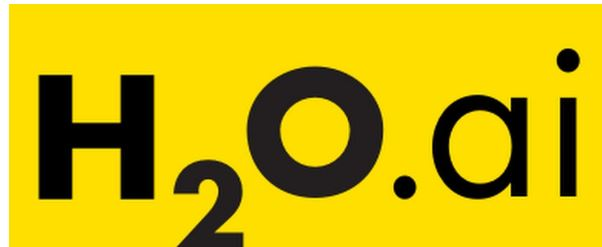

**Install Packages**

In [ ]:
#install_packages 
import h2o
from h2o.automl import H2OAutoML 
h2o.init() # h2o initialization 

In [ ]:
##  just add a new feature consisting of number of nan values in each row.
###check this discussion for more ( https://www.kaggle.com/c/tabular-playground-series-sep-2021/discussion/270206)
#train_data["nan_count"] = train_data.isnull().sum(axis=1)
#test_data["nan_count"]  = test_data.isnull().sum(axis=1)

In [ ]:
train= h2o.H2OFrame(train_data) # convert to h2o frame
test = h2o.H2OFrame(test_data) # convert to h2o frame 

**Prepare data**

In [ ]:
x = train.columns 
y = "claim" # target 
x.remove(y) # # X_train 
train[y] = train[y].asfactor() #binary classification 

**Train AutoML**

In [ ]:
auto_ml = H2OAutoML( 
    nfolds=5, # use 5 folds 
    seed = 1222,
    max_models = 10,
    include_algos = ["XGBoost" ,"StackedEnsemble","GBM"],
    max_runtime_secs=3600*2,  #time in sec , if set to much high value may give high score around 0.80...
    stopping_metric='AUC'
    )
auto_ml.train(x=x, y=y, training_frame=train)


**Check leaderboard**

In [ ]:
# check leaderboard
leader = auto_ml.leaderboard
leader

**Feature Importance**

In [ ]:
model = h2o.get_model(leader[2,"model_id"]) # get gbm model 
model.varimp_plot()

**Model Correlation Heatmap**


In [ ]:
mc_plot = auto_ml.model_correlation_heatmap(train)

**Learning Curve Plot**

In [ ]:
learning_curve_plot = model.learning_curve_plot()

### Generate Prediction

In [ ]:
preds = auto_ml.leader.predict(test)

In [ ]:
## create submission
submission = pd.DataFrame({
    'id': test['id'].as_data_frame().id,
    'claim': preds.as_data_frame().predict
})
submission.head()

In [ ]:
# save submission
submission.to_csv('h2o_submission.csv', index=False)

 ## Note: 
   <strong>This is just a starter where a lot of improvement can be made.You may look deeper into the data .for prediction you can always expriment with other techniques,models and frameworks...

<div class="alert alert-success">
  <h2><center>  I hope you find this useful , Thank you 🙏 </h2></center>
</div>
